     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0001041 0.1101417 0.2723688 0.4148248 0.5603247 2.5428292 


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




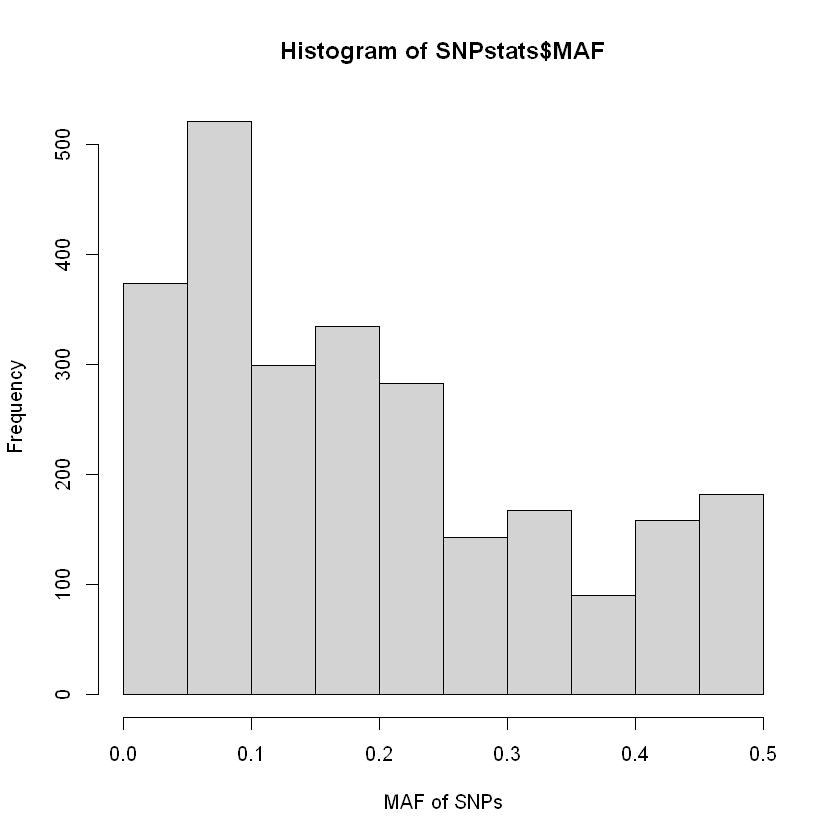

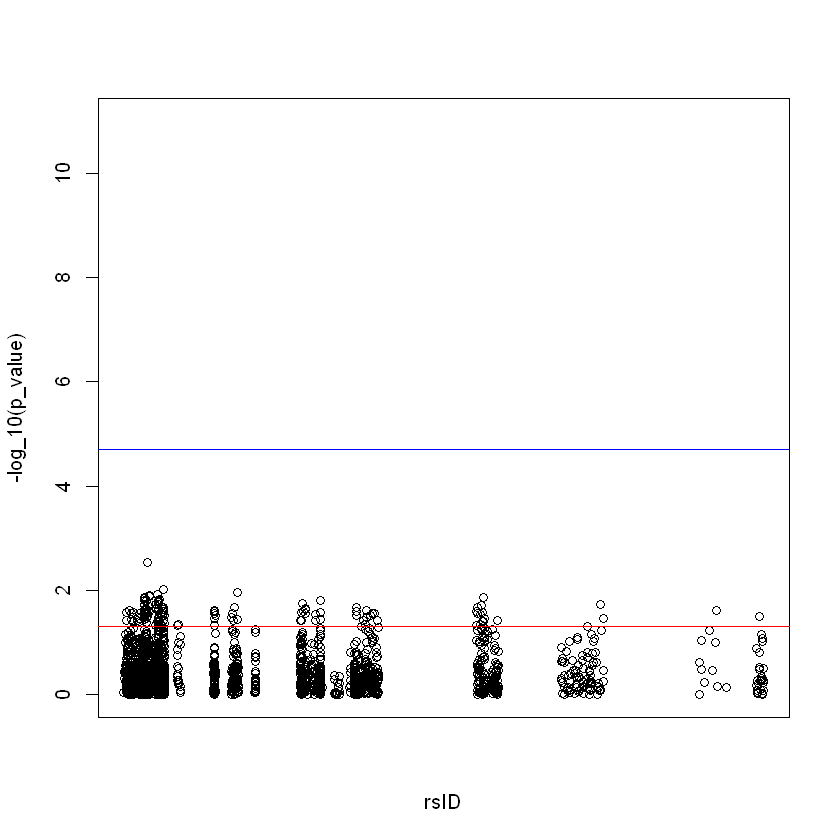

In [4]:
#Read in phenotype data
phen <- read.csv("C:/Users/adell/Desktop/adelle_price/adelle_price/phenotype.csv", stringsAsFactors=T)
#Make case/control data binary
phen$case.control <- ifelse(phen$phenotype == "case" , 1, 0)
#Read in genotype data as numeric (automatically codes for additive genotype assumption)
suppressPackageStartupMessages(library(snpStats))
bed.fn <- "C:/Users/adell/Desktop/adelle_price/adelle_price/common_11p15.bed"
fam.fn <- "C:/Users/adell/Desktop/adelle_price/adelle_price/common_11p15.fam"
bim.fn <- "C:/Users/adell/Desktop/adelle_price/adelle_price/common_11p15.bim"
gens <- read.plink(bed.fn, bim.fn, fam.fn)
geno <- as(gens$genotypes, "numeric")
#plot MAF of SNP data
Sampstats <- row.summary(gens$genotypes)
SNPstats <- col.summary(gens$genotypes)
hist(SNPstats$MAF, xlab = "MAF of SNPs")
#Make data frame for case/control analysis
full <- cbind.data.frame("ID" = phen$id, "Sex" = phen$SEX, "case.control" = phen$case.control, geno)

#Perform case/control analysis for each SNP
genes_length <- dim(geno)[2]
all_names <- colnames(full[,4:2555])
case_control = data.frame(matrix(, nrow=0, ncol=6))
for (i in 1:genes_length){
          Object <- glm(formula = case.control ~ full[[as.character(all_names[i])]] * Sex, data = full, family='binomial')
          names(Object$coefficients) = gsub("full[[as.character(all_names[i])]]", paste(all_names[i], "_"), names(Object$coefficients), fixed = TRUE)
          names(Object$coefficients) = gsub("(Intercept)", paste(all_names[i], "_(Intercept)"), names(Object$coefficients), fixed = TRUE)
          names(Object$coefficients) = gsub("SexMale", paste(all_names[i], "_SexMale"), names(Object$coefficients), fixed = TRUE)
          k = summary(Object)$coefficients
          f = names(Object$coefficients)
          z = cbind(k, "names" = rownames(k))
          f <- as.data.frame(f)
          data_all <- as.data.frame(merge(z, f, by.x = "names", by.y = "f", all = TRUE))
          case_control= rbind.data.frame(case_control, data_all)
        
    }


#Prepare case/control analysis results for Manhattan plot of significance per each interaction coefficient estimate p-value
Significant = case_control
Sig_Int <- Significant[grep("Intercept", Significant$names), ]
Sig_coef <- subset(Significant, !(rownames(Significant) %in% rownames(Sig_Int)))
Sig_coef <- na.omit(Sig_coef)
Sig_Marg <- Sig_coef[grep(":rs", Sig_coef$names), ]
Sig_Marg[,5] <- as.numeric(Sig_Marg[,5])
Sig_Marg$log_pval = -(log10(Sig_Marg[,5]))

suppressPackageStartupMessages(library(dplyr))
Sig_Marg <- Sig_Marg %>%                          
  mutate(ID = row_number())
Sig_Marg$names <- gsub("(:).*", "\\1", Sig_Marg$names)
Sig_Marg$names <- gsub(":", "", Sig_Marg$names)
Sig_Marg$rsid <- Sig_Marg$names
Sig_Marg$rsid <- gsub("(_).*", "\\1", Sig_Marg$rsid)
Sig_Marg$rsid <- gsub("_", "", Sig_Marg$rsid)
Sig_Marg$rsid <- gsub("rs", "", Sig_Marg$rsid)
Sig_Marg$rsid <- as.numeric(Sig_Marg$rsid)
Sig_Marg_o <- Sig_Marg[order(Sig_Marg$rsid),]


#Manhattan Plot of -log_10(pvals) of all SNP x Sex interaction terms from Case/Control analysis
plot(Sig_Marg_o$rsid, Sig_Marg_o$log_pval, xaxt = "n", xlab = "rsID", ylab = "-log_10(p_value)", ylim = c(0,11))
abline(h=(-(log10(.05))), col = "red")
abline(h=(-(log10(.05/genes_length))), col = "blue")


In [11]:
#Get SNPxSex interaction with highest significance from Case/Control analysis
Sig_Marg_p <- Sig_Marg[order(Sig_Marg[,5]),]
Sig_Marg_p[1,]

,names,Estimate,Std. Error,z value,Pr(>|z|),log_pval,ID,rsid
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>
4695,rs7396026 _,0.47772580262881,0.160212250731451,2.98183066805283,0.002865304,2.542829,1092,7396026


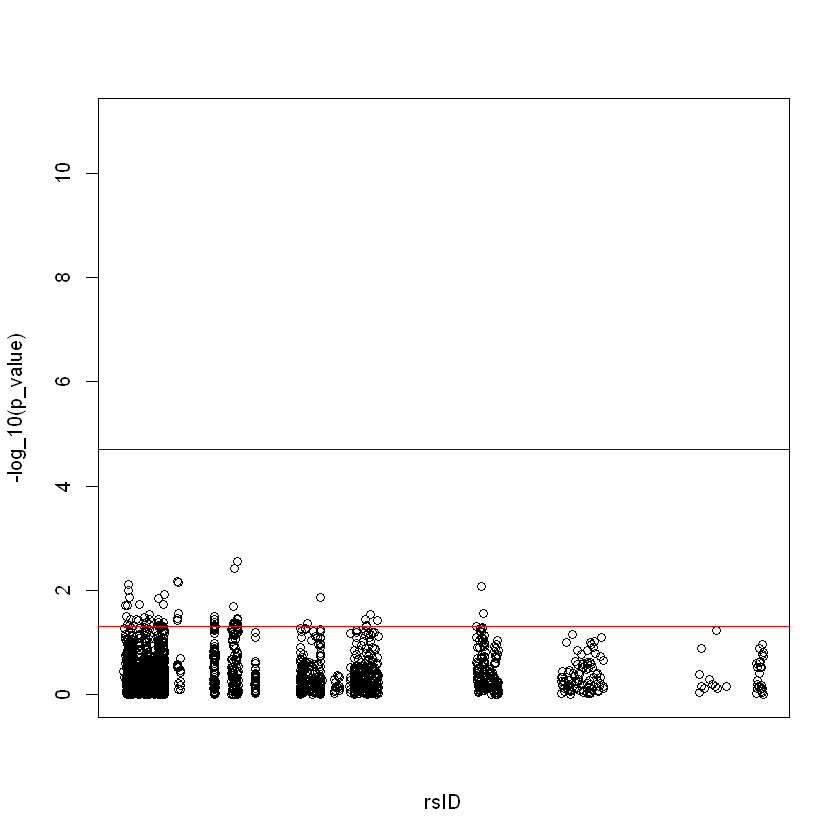

In [13]:
#Perform case only analysis for each SNP
genes_length <- dim(geno)[2]
full_case = full[full$case.control == 1,]
all_names <- colnames(full_case[,4:2555])
case_only = data.frame(matrix(, nrow=0, ncol=6))
for (i in 1:genes_length){
          Object <- glm(Sex ~ full_case[[as.character(all_names[i])]], data=full_case, family=binomial)
          names(Object$coefficients) = gsub("full_case[[as.character(all_names[i])]]", paste(all_names[i], "_"), names(Object$coefficients), fixed = TRUE)
          names(Object$coefficients) = gsub("(Intercept)", paste(all_names[i], "_(Intercept)"), names(Object$coefficients), fixed = TRUE)
          k = summary(Object)$coefficients
          f = names(Object$coefficients)
          z = cbind(k, "names" = rownames(k))
          f <- as.data.frame(f)
          data_all <- as.data.frame(merge(z, f, by.x = "names", by.y = "f", all = TRUE))
          case_only= rbind.data.frame(case_only, data_all)
    
        }

#Prepare case only analysis results for Manhattan plot of significance per each interaction coefficient estimate p-value
Significant = case_only
Sig_Int <- Significant[grep("Intercept", Significant$names), ]
Sig_coef <- subset(Significant, !(rownames(Significant) %in% rownames(Sig_Int)))
Sig_Marg_c <- na.omit(Sig_coef)
Sig_Marg_c[,5] <- as.numeric(Sig_Marg_c[,5])
Sig_Marg_c$log_pval = -(log10(Sig_Marg_c[,5]))
Sig_Marg_c$rsid <- Sig_Marg_c$names
Sig_Marg_c$rsid <- gsub("(_).*", "\\1", Sig_Marg_c$rsid)
Sig_Marg_c$rsid <- gsub("_", "", Sig_Marg_c$rsid)
Sig_Marg_c$rsid <- gsub("rs", "", Sig_Marg_c$rsid)
Sig_Marg_c$rsid <- gsub("chr11:", "", Sig_Marg_c$rsid)
Sig_Marg_c$rsid <- as.numeric(Sig_Marg_c$rsid)
Sig_Marg_o <- Sig_Marg_c[order(Sig_Marg_c$rsid),]

#Manhattan Plot of -log_10(pvals) of all SNP x Sex interaction terms from Case only analysis
plot(Sig_Marg_o$rsid, Sig_Marg_o$log_pval, xaxt = "n", xlab = "rsID", ylab = "-log_10(p_value)", ylim = c(0,11))
abline(h=(-(log10(.05))), col = "red")
abline(h=(-(log10(.05/genes_length))), col = "blue")

In [15]:
#Get two SNPxSex interactions with highest significance from Case only analysis
Sig_Marg_p <- Sig_Marg_c[order(Sig_Marg_c[,5]),]
Sig_Marg_p[1:2,]

,names,Estimate,Std. Error,z value,Pr(>|z|),log_pval,rsid
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
3971,rs35678986 _,0.335763385776304,0.112104514303207,2.99509246227293,0.002743617,2.561677,35678986
3053,rs34830395 _,0.322688147786073,0.111548877188729,2.89279601837784,0.003818292,2.418131,34830395


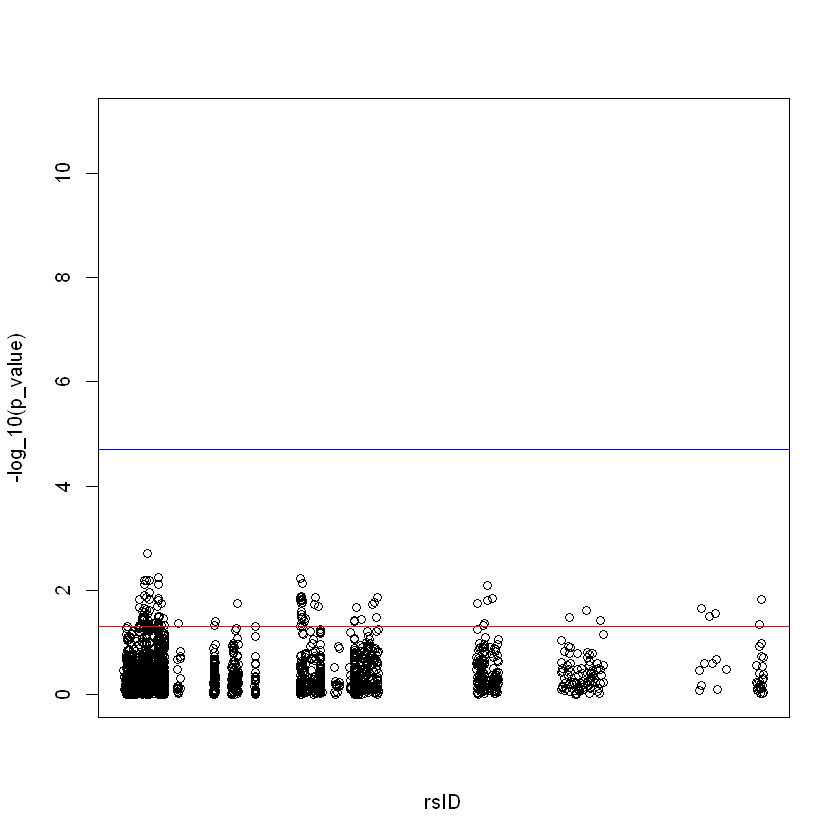

In [9]:
##Perform control only analysis for each SNP
genes_length <- dim(geno)[2]
full_control = full[full$case.control == 0,]
all_names <- colnames(full_control[,4:2555])
control_only = data.frame(matrix(, nrow=0, ncol=6))
for (i in 1:genes_length){
          Object <- glm(Sex ~ full_control[[as.character(all_names[i])]], data=full_control, family=binomial)
          names(Object$coefficients) = gsub("full_control[[as.character(all_names[i])]]", paste(all_names[i], "_"), names(Object$coefficients), fixed = TRUE)
          k = summary(Object)$coefficients
          f = names(Object$coefficients)
          z = cbind(k, "names" = rownames(k))
          f <- as.data.frame(f)
          data_all <- as.data.frame(merge(z, f, by.x = "names", by.y = "f", all = TRUE))
          control_only= rbind.data.frame(control_only, data_all)
    
        }

#Prepare control only analysis results for Manhattan plot of significance per each interaction coefficient estimate p-value
Significant = control_only
Sig_Int <- Significant[grep("rs", Significant$names), ]
Sig_Marg_con <- Sig_Int[order(Sig_Int[,5]),]
Sig_Marg_con[,5] <- as.numeric(Sig_Marg_con[,5])
Sig_Marg_con$log_pval = -(log10(Sig_Marg_con[,5]))
Sig_Marg_con$rsid <- Sig_Marg_con$names
Sig_Marg_con$rsid <- gsub("(_).*", "\\1", Sig_Marg_con$rsid)
Sig_Marg_con$rsid <- gsub("_", "", Sig_Marg_con$rsid)
Sig_Marg_con$rsid <- gsub("rs", "", Sig_Marg_con$rsid)
Sig_Marg_con$rsid <- gsub("chr11:", "", Sig_Marg_con$rsid)

Sig_Marg_con$rsid <- as.numeric(Sig_Marg_con$rsid)
Sig_Marg_o <- Sig_Marg_con[order(Sig_Marg_con$rsid),]
plot(Sig_Marg_o$rsid, Sig_Marg_o$log_pval, xaxt = "n", xlab = "rsID", ylab = "-log_10(p_value)", ylim = c(0,11))
abline(h=(-(log10(.05))), col = "red")
abline(h=(-(log10(.05/genes_length))), col = "blue")


In [16]:
#Get the coefficient estimates and confidence intervals for the Case/Control analysis top significance SNPxSex interaction 
snp <- full$rs7396026
sex <- full$Sex
case.control <- full$case.control
dat = cbind.data.frame(sex,case.control,snp)
Object <- glm(formula = case.control ~ snp * sex, data = dat, family='binomial')
summary(Object)
confint(Object)

#Get the coefficient estimates and confidence intervals for the Case only analysis top two significance SNPxSex interaction 
full <- full[full$case.control == "1",]
snp <- full$rs34830395
sex <- full$Sex
case.control <- full$case.control
dat = cbind.data.frame(sex,case.control,snp)
Object <- glm(formula = sex~snp, data = dat, family='binomial')
summary(Object)
confint(Object)

snp <- full$rs35678986
sex <- full$Sex
case.control <- full$case.control
dat = cbind.data.frame(sex,case.control,snp)
Object <- glm(formula = sex~snp, data = dat, family='binomial')
summary(Object)
confint(Object)


Call:
glm(formula = case.control ~ snp * sex, family = "binomial", 
    data = dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3404  -0.8646  -0.8121   1.0227   1.5937  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  -0.6429     0.2397  -2.682  0.00732 **
snp          -0.1486     0.1241  -1.197  0.23120   
sexMale       0.3602     0.3091   1.165  0.24395   
snp:sexMale   0.4777     0.1602   2.982  0.00287 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 11088  on 8058  degrees of freedom
Residual deviance: 10326  on 8055  degrees of freedom
AIC: 10334

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-1.1204596,-0.17943549
snp,-0.3889956,0.09827259
sexMale,-0.2418716,0.97067873
snp:sexMale,0.1615563,0.78998387



Call:
glm(formula = sex ~ snp, family = "binomial", data = dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5991  -1.4537   0.8079   0.8079   1.0502  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)   0.3067     0.2135   1.437  0.15073   
snp           0.3227     0.1115   2.893  0.00382 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4327.1  on 3616  degrees of freedom
Residual deviance: 4319.0  on 3615  degrees of freedom
AIC: 4323

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-0.1079256,0.7298501
snp,0.1019258,0.5396596



Call:
glm(formula = sex ~ snp, family = "binomial", data = dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5995  -1.5995   0.8076   0.8076   1.0604  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)   0.2815     0.2147   1.311  0.18970   
snp           0.3358     0.1121   2.995  0.00274 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4327.1  on 3616  degrees of freedom
Residual deviance: 4318.4  on 3615  degrees of freedom
AIC: 4322.4

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-0.1355564,0.7068977
snp,0.1139337,0.5538556
